We all get it - AI is the new electricity. Deep neural nets are everywhere around us. But you know what, getting labelled training data can still be a big issue in many domains. This is where active learning comes in - given that we only have a small amount of labelled data, do we randomly get labels for other samples, or can we create a `smarter` strategy for the same? Active learning deals with the latter.

Various strategies for active learning have been proposed in the past. In this post, I'll work out a trivial example of what is called query by committee. The key idea is that we create a committee of learners and choose to acquire labels for the unlabelled points for which there is maximum disaggrement amongst the committee.

I'd recommend the new readers to go through [this](http://burrsettles.com/pub/settles.activelearning.pdf) survey.

In this particular post, I'd be looking at active learning via query by committee, where the committee members are trained on different subsets of the train data. In a future post, I'll write about active learning via query by committee, where the committee members are trained on the same data, but with different parameters.

#### Standard imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(0)
%matplotlib inline

#### Creating dataset

In [2]:
X = np.arange(1, 1001, 1)
Y = 10*X + 4 + 400* np.random.randn(1000, ) 

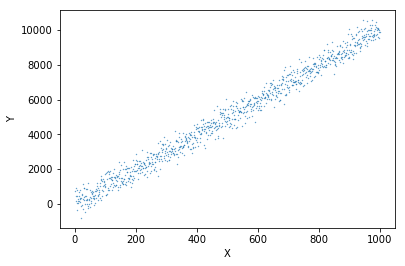

In [3]:
plt.scatter(X, Y, s=0.1)
plt.xlabel("X")
plt.ylabel("Y")

#### Learning a linear regression model on the entire data

In [4]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

In [5]:
clf.fit(X.reshape(-1,1), Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
clf.intercept_

-10.370897712972692

In [7]:
clf.coef_

array([ 9.99254389])

#### Visualising the fit

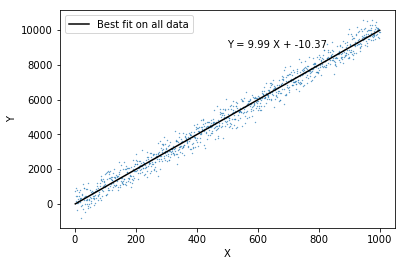

In [8]:
plt.scatter(X, Y, s=0.1)
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X, clf.coef_[0]*X + clf.intercept_, color='k', label='Best fit on all data')
plt.legend()
plt.text(500, clf.coef_[0]*500 + clf.intercept_ +4000, "Y = {0:0.2f} X + {1:0.2f}".format(clf.coef_[0], clf.intercept_) )

#### Creating the initial train set, the test set and the pool

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_pool_X, test_X, train_pool_Y, test_Y = train_test_split(X, Y, test_size = 0.5)

In [11]:
train_X, pool_X, train_Y, pool_Y = train_test_split(train_pool_X, train_pool_Y, test_size=495)

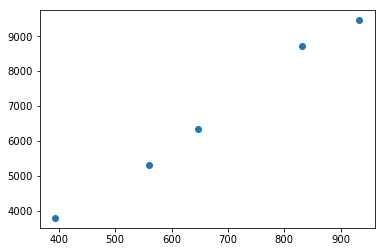

In [12]:
plt.scatter(train_X, train_Y)

#### Creating a committee each learnt on different subset of the data

In [13]:
committee_size = 5

In [14]:
train_X_com = {0:{}}
train_Y_com = {0:{}}
models_com = {0:{}}

iteration = 0

for cur_committee in range(committee_size):
    train_X_com[iteration][cur_committee], _, train_Y_com[iteration][cur_committee], _ = train_test_split(train_X, train_Y, train_size=0.5, 
                                                                              random_state=cur_committee)
    models_com[iteration][cur_committee] = LinearRegression()
    models_com[iteration][cur_committee].fit(train_X_com[iteration][cur_committee].reshape(-1,1), train_Y_com[iteration][cur_committee])

/Users/nipun/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Plotting the fit of the committee on the entire dataset

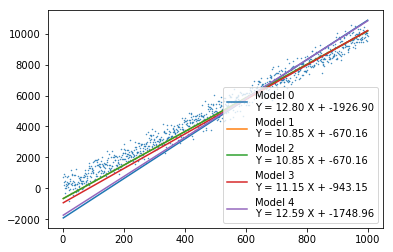

In [15]:
plt.scatter(X, Y, s=0.2)
for cur_committee in range(committee_size):
    plt.plot(X, models_com[0][cur_committee].coef_[0]*X + models_com[0][cur_committee].intercept_,
             label='Model {0}\nY = {1:0.2f} X + {2:0.2f}'.format(cur_committee,
                                                                 models_com[0][cur_committee].coef_[0],
                                                                models_com[0][cur_committee].intercept_))
    plt.legend()

#### Evaluate the performance on the test set

In [16]:
estimations_com = {0:{}}
for cur_committee in range(committee_size):
    estimations_com[0][cur_committee] = models_com[0][cur_committee].predict(test_X.reshape(-1, 1))

In [17]:
test_mae_error = {0:(pd.DataFrame(estimations_com[0]).mean(axis=1) - test_Y).abs().mean()}

The MAE on the test set is:

In [18]:
test_mae_error[0]

565.8837967341798

#### Active learning procedure

In [19]:
num_iterations = 20
points_added_x=[]

points_added_y=[]

print("Iteration, Cost\n")
print("-"*40)

for iteration in range(1, num_iterations):
    # For each committee: making predictions on the pool set based on model learnt in the respective train set 
    estimations_pool = {cur_committee: models_com[iteration-1][cur_committee].predict(pool_X.reshape(-1, 1)) for cur_committee in range(committee_size)}
    # Finding points from the pool with highest disagreement among the committee - highest standard deviation
    in_var = pd.DataFrame(estimations_pool).std(axis=1).argmax()
    
    to_add_x = pool_X[in_var]
    to_add_y = pool_Y[in_var]
    points_added_x.append(to_add_x)
    points_added_y.append(to_add_y)
    
    # For each committee - Adding the point where the committe most disagrees
    for com in range(committee_size):
        if iteration not in train_X_com:
            train_X_com[iteration] = {}
            train_Y_com[iteration] = {}
            models_com[iteration] = {}
        train_X_com[iteration][com] = np.append(train_X_com[iteration-1][com], to_add_x)
        train_Y_com[iteration][com] = np.append(train_Y_com[iteration-1][com], to_add_y)
    
    # Deleting the point from the pool
    pool_X = np.delete(pool_X, in_var)
    pool_Y = np.delete(pool_Y, in_var)
    
    # Training on the new set for each committee
    for cur_committee in range(committee_size):
        models_com[iteration][cur_committee] = LinearRegression()
        models_com[iteration][cur_committee].fit(train_X_com[iteration][cur_committee].reshape(-1,1), train_Y_com[iteration][cur_committee])
    
    estimations_com[iteration] = {}
    for cur_committee in range(committee_size):
        estimations_com[iteration][cur_committee] = models_com[iteration][cur_committee].predict(test_X.reshape(-1, 1))
    test_mae_error[iteration]=(pd.DataFrame(estimations_com[iteration]).mean(axis=1) - test_Y).abs().mean()
    print(iteration, (test_mae_error[iteration]))

Iteration, Cost

----------------------------------------
1 406.17664898054875
2 402.9897752715986
3 348.45182739054235
4 348.49519515039907
5 349.04197938475716
6 348.68188577804807
7 352.40882668573266
8 373.60417208279864
9 377.25044571705723
10 372.5302143045216
11 335.30243056115603
12 336.6073606660666
13 343.2867837998923
14 347.0491266373306
15 349.7464195274436
16 351.5990833631039
17 349.21957548034976
18 338.8765223206476
19 337.0132510959355


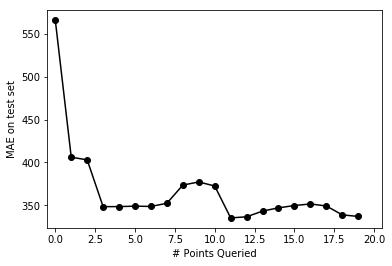

In [20]:
pd.Series(test_mae_error).plot(style='ko-')
plt.xlim((-0.5, num_iterations+0.5))
plt.ylabel("MAE on test set")
plt.xlabel("# Points Queried")

As expected, the error goes down as we increase the number of points queried

In [32]:
fig, ax = plt.subplots()
import os
from matplotlib.animation import FuncAnimation
plt.rcParams['animation.ffmpeg_path'] = os.path.expanduser('/Users/nipun/anaconda3/bin/ffmpeg')
def update(iteration):
    ax.cla()
    ax.scatter(X, Y, s=0.2)
    ax.set_title("Iteration: {} \n MAE = {:0.2f}".format(iteration, test_mae_error[iteration]))
    for cur_committee in range(committee_size):
        ax.plot(X, models_com[iteration][cur_committee].coef_[0]*X + models_com[iteration][cur_committee].intercept_,
             label='Model {0}\nY = {1:0.2f} X + {2:0.2f}'.format(cur_committee,
                                                                 models_com[iteration][cur_committee].coef_[0],
                                                                models_com[iteration][cur_committee].intercept_))
        
        ax.scatter(points_added_x[iteration], points_added_y[iteration],s=100, color='red')
    ax.legend()
    
    fig.tight_layout()

anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=1000)
plt.close()

In [33]:
from IPython.display import HTML
HTML(anim.to_html5_video())

From the animation, we can see that how adding a new point to the train set (shown in red) reduces the variation in prediction amongst the different committee members.